# Diminishing Returns of Traditional 401k Investment

This notebook explores the optimal split between Traditional (Pre-Tax) and Roth contributions. Specifically, we investigate the point of diminishing returns for Traditional contributions where switching to Roth becomes more beneficial.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

from app.analysis import run_full_simulation

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Baseline Parameters

We define a standard set of parameters for our simulation.


In [ ]:
params = {
    "annual_income": 300000,
    "current_age": 35,
    "retirement_age": 65,
    "final_age": 90,
    "accumulation_return": 0.08,
    "retirement_return": 0.05,
    "contribution_input": 23000,  # Max out usually
    "use_max_contribution": True,
    "employer_match_percent": 0.0,
    "employer_match_limit": 0.0,
    "invest_tax_savings_percent": 1.0,
    "annual_raise_percent": 0.03,
    "retirement_income": 0, # Assuming social security still exists - this is a bad assumption 
    "inflation_rate": 0.025,
    "capital_gains_rate": 0.15,
    "current_401k_balance": 0.0,
    "current_roth_balance": 0.0
}


## Helper Function

A helper to run simulations across a range of Roth Splits (0% to 100%).


In [28]:
def analyze_splits(custom_params):
    splits = np.linspace(0, 1, 21)
    results = []

    for split in splits:
        p = custom_params.copy()
        p['roth_split_percent'] = split
        
        # Run only the split strategy part mostly, but simulation runs all 3.
        # We'll extract the 'split' result.
        sim_res = run_full_simulation(**p)
        dist = sim_res['distribution_split']
        
        # Metrics
        total_net_income = dist['Net_Income'].sum()
        avg_annual_net_income = dist['Net_Income'].mean()
        
        results.append({
            'Roth_Split_Percent': split,
            'Total_Net_Lifetime_Income': total_net_income,
            'Avg_Annual_Net_Income': avg_annual_net_income
        })
        
    return pd.DataFrame(results)


## Experiment 1: The "Sweet Spot" Curve
With baseline parameters (Income $100k, 0 starting balance), let's see optimal split.


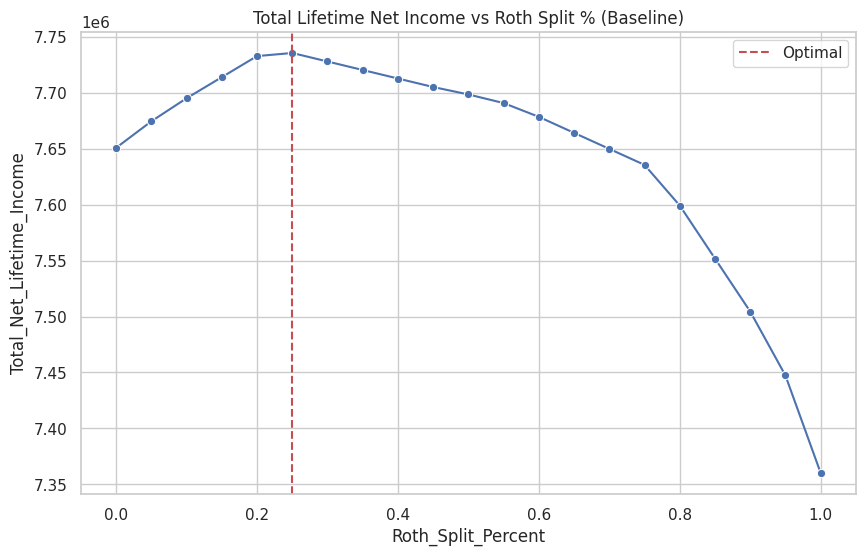

In [29]:
df_base = analyze_splits(params)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_base, x='Roth_Split_Percent', y='Total_Net_Lifetime_Income', marker='o')
plt.title('Total Lifetime Net Income vs Roth Split % (Baseline)')
plt.axvline(df_base.loc[df_base['Total_Net_Lifetime_Income'].idxmax()]['Roth_Split_Percent'], color='r', linestyle='--', label='Optimal')
plt.legend()
plt.show()


## Experiment 2: Effect of Starting Pre-Tax Balance
The user hypothesized that having a large Pre-Tax balance makes Roth more attractive (diminishing returns on Traditiona).
Let's test this by varying `current_401k_balance`.


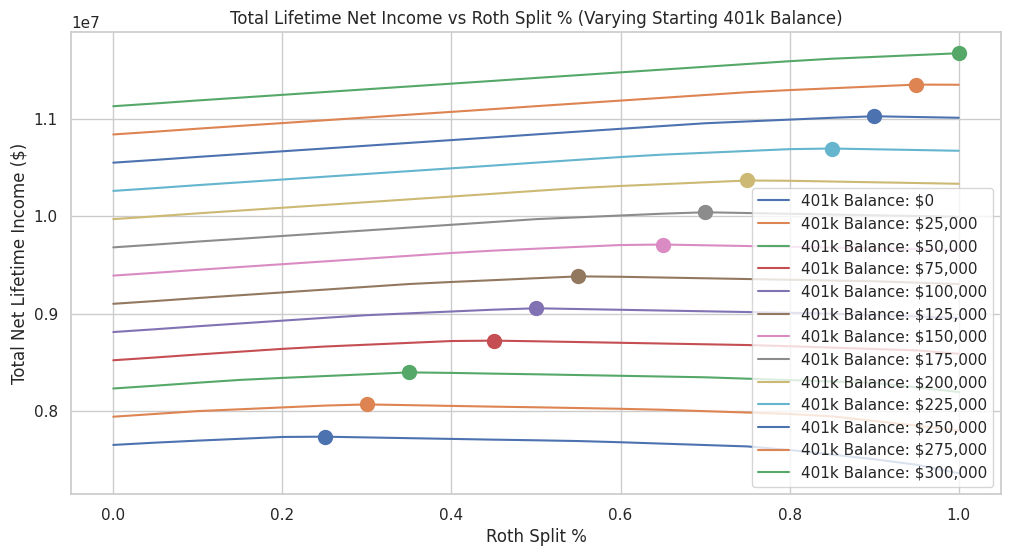

In [30]:
balances = [i for i in range(0, 300001, 25000)]
results_by_balance = {}

for bal in balances:
    p = params.copy()
    p['current_401k_balance'] = bal
    results_by_balance[bal] = analyze_splits(p)

plt.figure(figsize=(12, 6))
ax = plt.gca()
for bal, df in results_by_balance.items():
    # Plot the line
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Total_Net_Lifetime_Income', label=f'401k Balance: ${bal:,}', ax=ax)

    # Find the maximum point for the current line
    max_income_row = df.loc[df['Total_Net_Lifetime_Income'].idxmax()]
    max_x = max_income_row['Roth_Split_Percent']
    max_y = max_income_row['Total_Net_Lifetime_Income']

    # Get the color of the most recently plotted line
    current_line_color = ax.lines[-1].get_color()

    # Plot a circle marker at the highest point with the same color
    ax.scatter(max_x, max_y, color=current_line_color, s=100, marker='o', zorder=5)

plt.title('Total Lifetime Net Income vs Roth Split % (Varying Starting 401k Balance)')
plt.xlabel('Roth Split %')
plt.ylabel('Total Net Lifetime Income ($)')
plt.legend()
plt.show()


## Experiment 3: Effect of Income Level
Higher income => higher marginal tax bracket => more benefit from Traditional (up to a point).
We normalize the results to compare the shape of the curves.


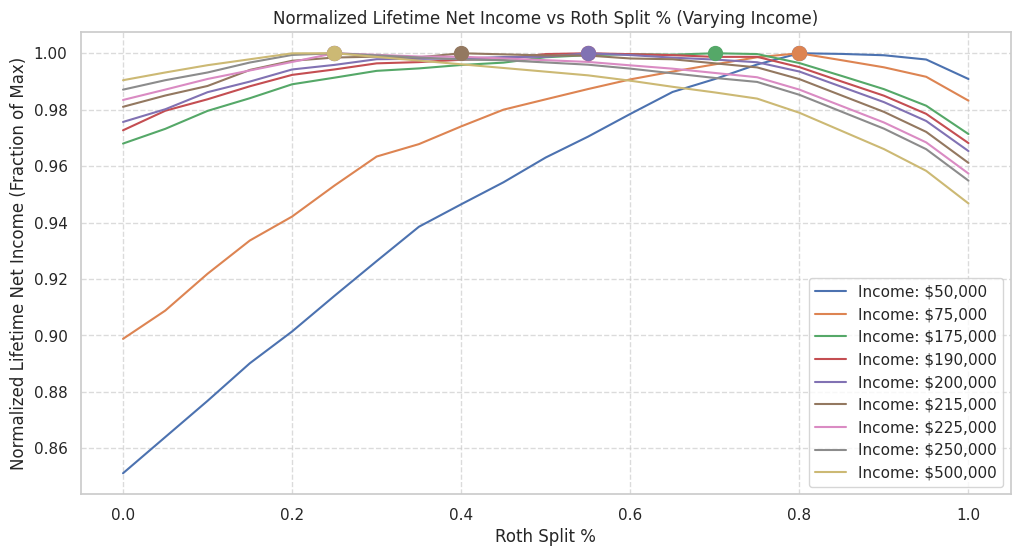


Optimal Roth Split Percentages:


,Income,Optimal Roth Split %,Max Normalized Income
0,50000,0.80,1.0
1,75000,0.80,1.0
2,175000,0.70,1.0
3,190000,0.55,1.0
4,200000,0.55,1.0
5,215000,0.40,1.0
6,225000,0.25,1.0
7,250000,0.25,1.0
8,500000,0.25,1.0


In [6]:
incomes = [50000, 75000, 175000, 190000, 200000, 215000, 225000, 250000, 500000]
results_by_income = {}

for inc in incomes:
    p = params.copy()
    p['annual_income'] = inc
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_income[inc] = df

optimal_splits = []
plt.figure(figsize=(12, 6))
for inc, df in results_by_income.items():
    # Find the row with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split_percent = max_income_row['Roth_Split_Percent']
    max_normalized_income = max_income_row['Normalized_Income']

    # Plot the line
    line = sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Income: ${inc:,}')
    line_color = line.get_lines()[-1].get_color() # Get the color of the last plotted line

    # Plot the optimal point
    plt.scatter(optimal_split_percent, max_normalized_income, color=line_color, s=100, zorder=5)

    optimal_splits.append({
        'Income': inc,
        'Optimal Roth Split %': optimal_split_percent,
        'Max Normalized Income': max_normalized_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Income)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print the table of optimal splits
print("\nOptimal Roth Split Percentages:")
optimal_df = pd.DataFrame(optimal_splits)
display(optimal_df)


## Experiment 4: Effect of Starting Age
Younger starting age means more years of compounding, which may affect the optimal split.
Results are normalized for comparison.


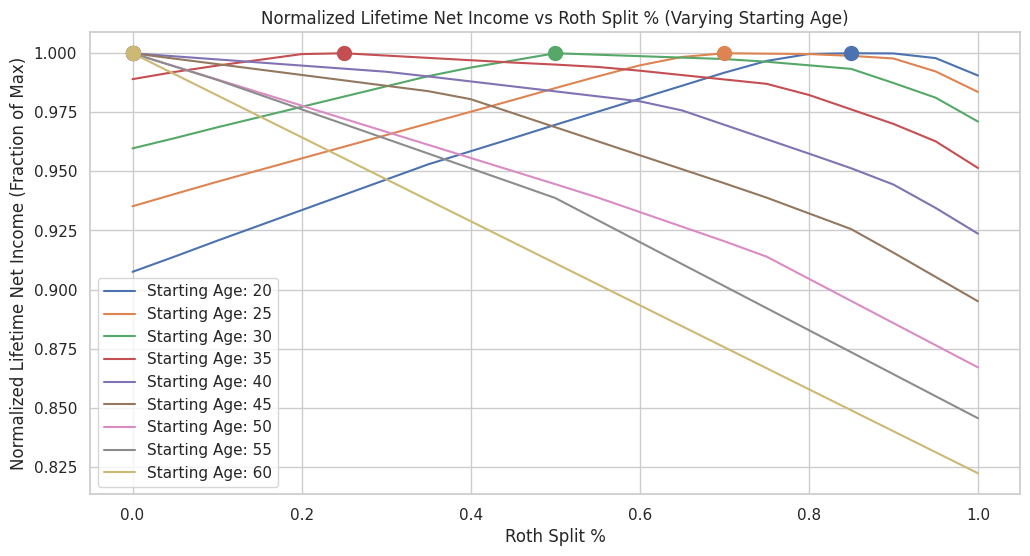


Optimal Roth Split Percentages:


,Starting Age,Optimal Roth Split %,Max Normalized Income
0,20,0.85,1.0
1,25,0.70,1.0
2,30,0.50,1.0
3,35,0.25,1.0
4,40,0.00,1.0
5,45,0.00,1.0
6,50,0.00,1.0
7,55,0.00,1.0
8,60,0.00,1.0


In [7]:
ages = [20, 25, 30, 35, 40, 45, 50, 55, 60]
results_by_age = {}

for age in ages:
    p = params.copy()
    p['current_age'] = age
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_age[age] = df

optimal_results = []
plt.figure(figsize=(12, 6))
for age, df in results_by_age.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Starting Age: {age}')
    
    # Get the color of the line that was just plotted
    line_color = plt.gca().lines[-1].get_color()
    
    # Find the point with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split = max_income_row['Roth_Split_Percent']
    max_income = max_income_row['Normalized_Income']
    
    # Highlight the optimal point with a circle of the same color
    plt.scatter(optimal_split, max_income, color=line_color, s=100, marker='o', zorder=5)

    optimal_results.append({
        'Starting Age': age,
        'Optimal Roth Split %': optimal_split,
        'Max Normalized Income': max_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Starting Age)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_df = pd.DataFrame(optimal_results)
print("\nOptimal Roth Split Percentages:")
display(optimal_df)


## Experiment 5: Effect of Employer Match
Employer match provides free money, which may affect the optimal split strategy.
Results are normalized for comparison.


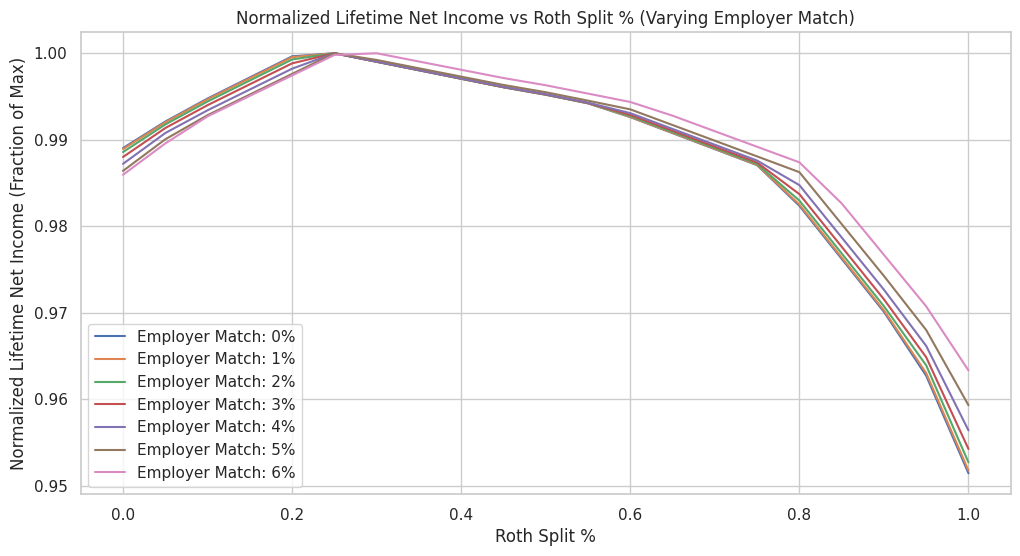

Employer_Match_Percent Optimal_Roth_Split_Percent  Max_Normalized_Income
                    0%                        25%                    1.0
                    1%                        25%                    1.0
                    2%                        25%                    1.0
                    3%                        25%                    1.0
                    4%                        25%                    1.0
                    5%                        25%                    1.0
                    6%                        30%                    1.0


In [8]:
match_rates = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
results_by_match = {}

for match in match_rates:
    p = params.copy()
    p['employer_match_percent'] = match
    p['employer_match_limit'] = match  # Assuming 100% match up to the percentage
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_match[match] = df

plt.figure(figsize=(12, 6))
for match, df in results_by_match.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Employer Match: {match*100:.0f}%')

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Employer Match)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_splits = []
for match, df in results_by_match.items():
    optimal_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_splits.append({
        'Employer_Match_Percent': f'{match*100:.0f}%',
        'Optimal_Roth_Split_Percent': f'{optimal_row["Roth_Split_Percent"]*100:.0f}%',
        'Max_Normalized_Income': optimal_row['Normalized_Income']
    })

import pandas as pd
optimal_splits_df = pd.DataFrame(optimal_splits)
print(optimal_splits_df.to_string(index=False))


## Experiment 6: Effect of Final Age (Life Expectancy)
Life expectancy affects how long you'll be in retirement drawing from your accounts. 
A shorter retirement may favor Traditional 401k (less time for Roth tax-free growth), 
while a longer retirement may favor Roth (more tax-free distributions).
Results are normalized for comparison.

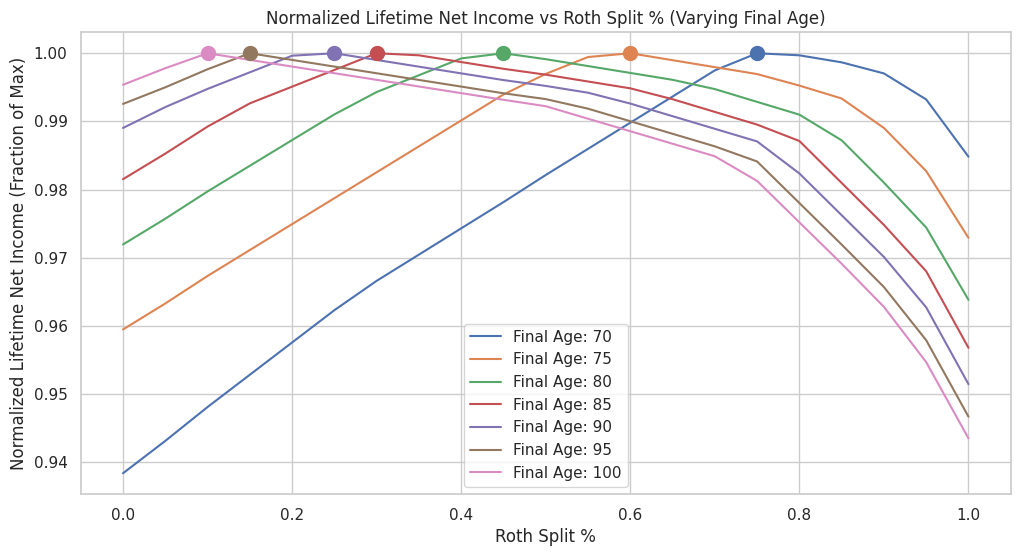


Optimal Roth Split Percentages by Life Expectancy:


,Final Age,Retirement Years,Optimal Roth Split %,Max Normalized Income
0,70,5,0.75,1.0
1,75,10,0.60,1.0
2,80,15,0.45,1.0
3,85,20,0.30,1.0
4,90,25,0.25,1.0
5,95,30,0.15,1.0
6,100,35,0.10,1.0


In [9]:
final_ages = [70, 75, 80, 85, 90, 95, 100]
results_by_final_age = {}

for final_age in final_ages:
    p = params.copy()
    p['final_age'] = final_age
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_final_age[final_age] = df

optimal_results = []
plt.figure(figsize=(12, 6))
for final_age, df in results_by_final_age.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', label=f'Final Age: {final_age}')
    
    # Get the color of the line that was just plotted
    line_color = plt.gca().lines[-1].get_color()
    
    # Find the point with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split = max_income_row['Roth_Split_Percent']
    max_income = max_income_row['Normalized_Income']
    
    # Highlight the optimal point with a circle of the same color
    plt.scatter(optimal_split, max_income, color=line_color, s=100, marker='o', zorder=5)

    optimal_results.append({
        'Final Age': final_age,
        'Retirement Years': final_age - 65,  # Assuming retirement at 65
        'Optimal Roth Split %': optimal_split,
        'Max Normalized Income': max_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Final Age)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_df = pd.DataFrame(optimal_results)
print("\nOptimal Roth Split Percentages by Life Expectancy:")
display(optimal_df)


## Experiment 7: Total Income vs Total PreTax Income Comparison
This experiment compares total lifetime net income against total lifetime pretax withdrawals 
to understand the relationship between traditional 401k income and overall retirement income.

In [10]:
def analyze_splits_detailed(custom_params):
    """
    Enhanced version of analyze_splits that captures both total net income 
    and total pretax withdrawals for comparison.
    """
    splits = np.linspace(0, 1, 21)
    results = []

    for split in splits:
        p = custom_params.copy()
        p['roth_split_percent'] = split
        
        # Run simulation
        sim_res = run_full_simulation(**p)
        dist = sim_res['distribution_split']
        
        # Metrics
        total_net_income = dist['Net_Income'].sum()
        total_pretax_withdrawals = dist['Withdrawal_PreTax'].sum()
        total_roth_withdrawals = dist['Withdrawal_Roth'].sum()
        total_taxable_withdrawals = dist['Withdrawal_Taxable'].sum()
        total_taxes = dist['Total_Tax'].sum()
        avg_annual_net_income = dist['Net_Income'].mean()
        
        results.append({
            'Roth_Split_Percent': split,
            'Total_Net_Lifetime_Income': total_net_income,
            'Total_PreTax_Withdrawals': total_pretax_withdrawals,
            'Total_Roth_Withdrawals': total_roth_withdrawals,
            'Total_Taxable_Withdrawals': total_taxable_withdrawals,
            'Total_Lifetime_Taxes': total_taxes,
            'Avg_Annual_Net_Income': avg_annual_net_income,
            'PreTax_Percentage_of_Income': total_pretax_withdrawals / total_net_income if total_net_income > 0 else 0
        })
        
    return pd.DataFrame(results)


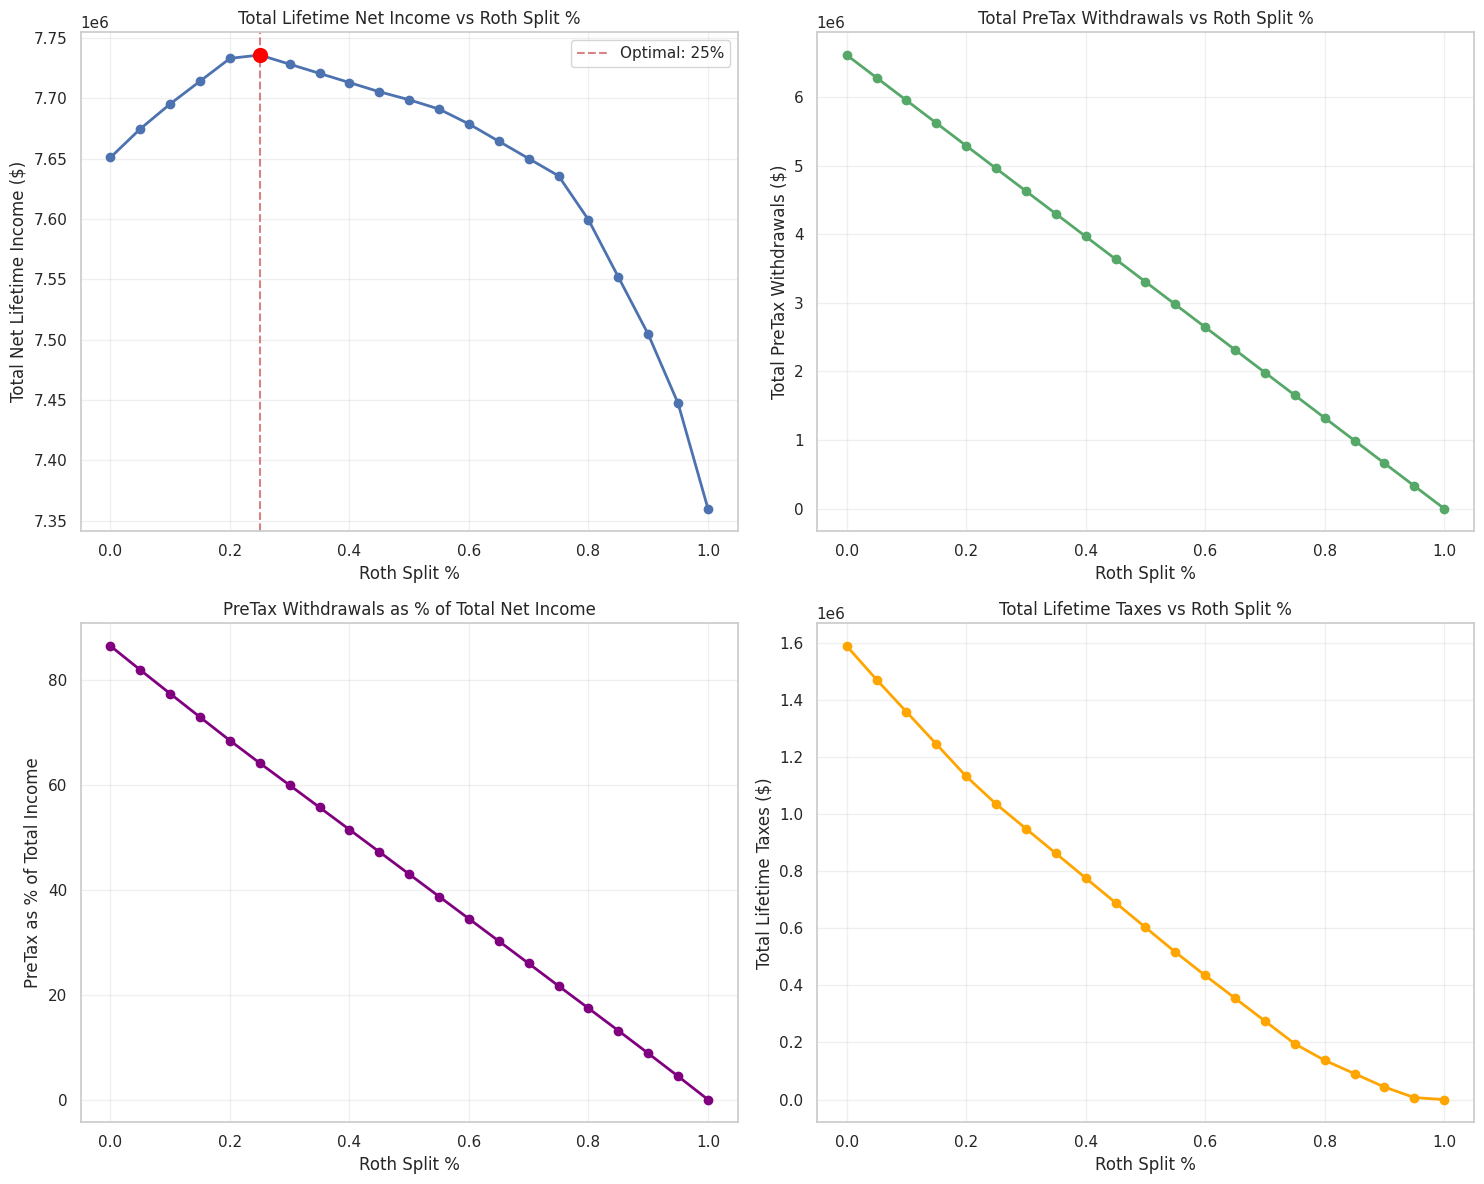

\nDetailed Analysis Summary:
Optimal Roth Split: 25.0%
At Optimal Split:
  - Total Net Income: $7,735,795
  - Total PreTax Withdrawals: $4,962,829
  - Total Roth Withdrawals: $2,397,239
  - Total Taxes: $1,035,374
  - PreTax as % of Income: 64.2%


In [11]:
# Run the detailed analysis with baseline parameters
df_detailed = analyze_splits_detailed(params)

# Create subplots to show multiple comparisons
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Net Income vs Roth Split (same as Experiment 1)
ax1.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_Net_Lifetime_Income'], 'b-o', linewidth=2)
optimal_idx = df_detailed['Total_Net_Lifetime_Income'].idxmax()
optimal_split = df_detailed.loc[optimal_idx, 'Roth_Split_Percent']
optimal_income = df_detailed.loc[optimal_idx, 'Total_Net_Lifetime_Income']
ax1.axvline(optimal_split, color='r', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_split:.0%}')
ax1.scatter(optimal_split, optimal_income, color='red', s=100, zorder=5)
ax1.set_title('Total Lifetime Net Income vs Roth Split %')
ax1.set_xlabel('Roth Split %')
ax1.set_ylabel('Total Net Lifetime Income ($)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Total PreTax Withdrawals vs Roth Split
ax2.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_PreTax_Withdrawals'], 'g-o', linewidth=2)
ax2.set_title('Total PreTax Withdrawals vs Roth Split %')
ax2.set_xlabel('Roth Split %')
ax2.set_ylabel('Total PreTax Withdrawals ($)')
ax2.grid(True, alpha=0.3)

# Plot 3: PreTax as Percentage of Total Income
ax3.plot(df_detailed['Roth_Split_Percent'], df_detailed['PreTax_Percentage_of_Income'] * 100, 'purple', marker='o', linewidth=2)
ax3.set_title('PreTax Withdrawals as % of Total Net Income')
ax3.set_xlabel('Roth Split %')
ax3.set_ylabel('PreTax as % of Total Income')
ax3.grid(True, alpha=0.3)

# Plot 4: Total Taxes vs Roth Split
ax4.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_Lifetime_Taxes'], 'orange', marker='o', linewidth=2)
ax4.set_title('Total Lifetime Taxes vs Roth Split %')
ax4.set_xlabel('Roth Split %')
ax4.set_ylabel('Total Lifetime Taxes ($)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display a summary table
print("\\nDetailed Analysis Summary:")
print(f"Optimal Roth Split: {optimal_split:.1%}")
print(f"At Optimal Split:")
print(f"  - Total Net Income: ${optimal_income:,.0f}")
print(f"  - Total PreTax Withdrawals: ${df_detailed.loc[optimal_idx, 'Total_PreTax_Withdrawals']:,.0f}")
print(f"  - Total Roth Withdrawals: ${df_detailed.loc[optimal_idx, 'Total_Roth_Withdrawals']:,.0f}")
print(f"  - Total Taxes: ${df_detailed.loc[optimal_idx, 'Total_Lifetime_Taxes']:,.0f}")
print(f"  - PreTax as % of Income: {df_detailed.loc[optimal_idx, 'PreTax_Percentage_of_Income']:.1%}")


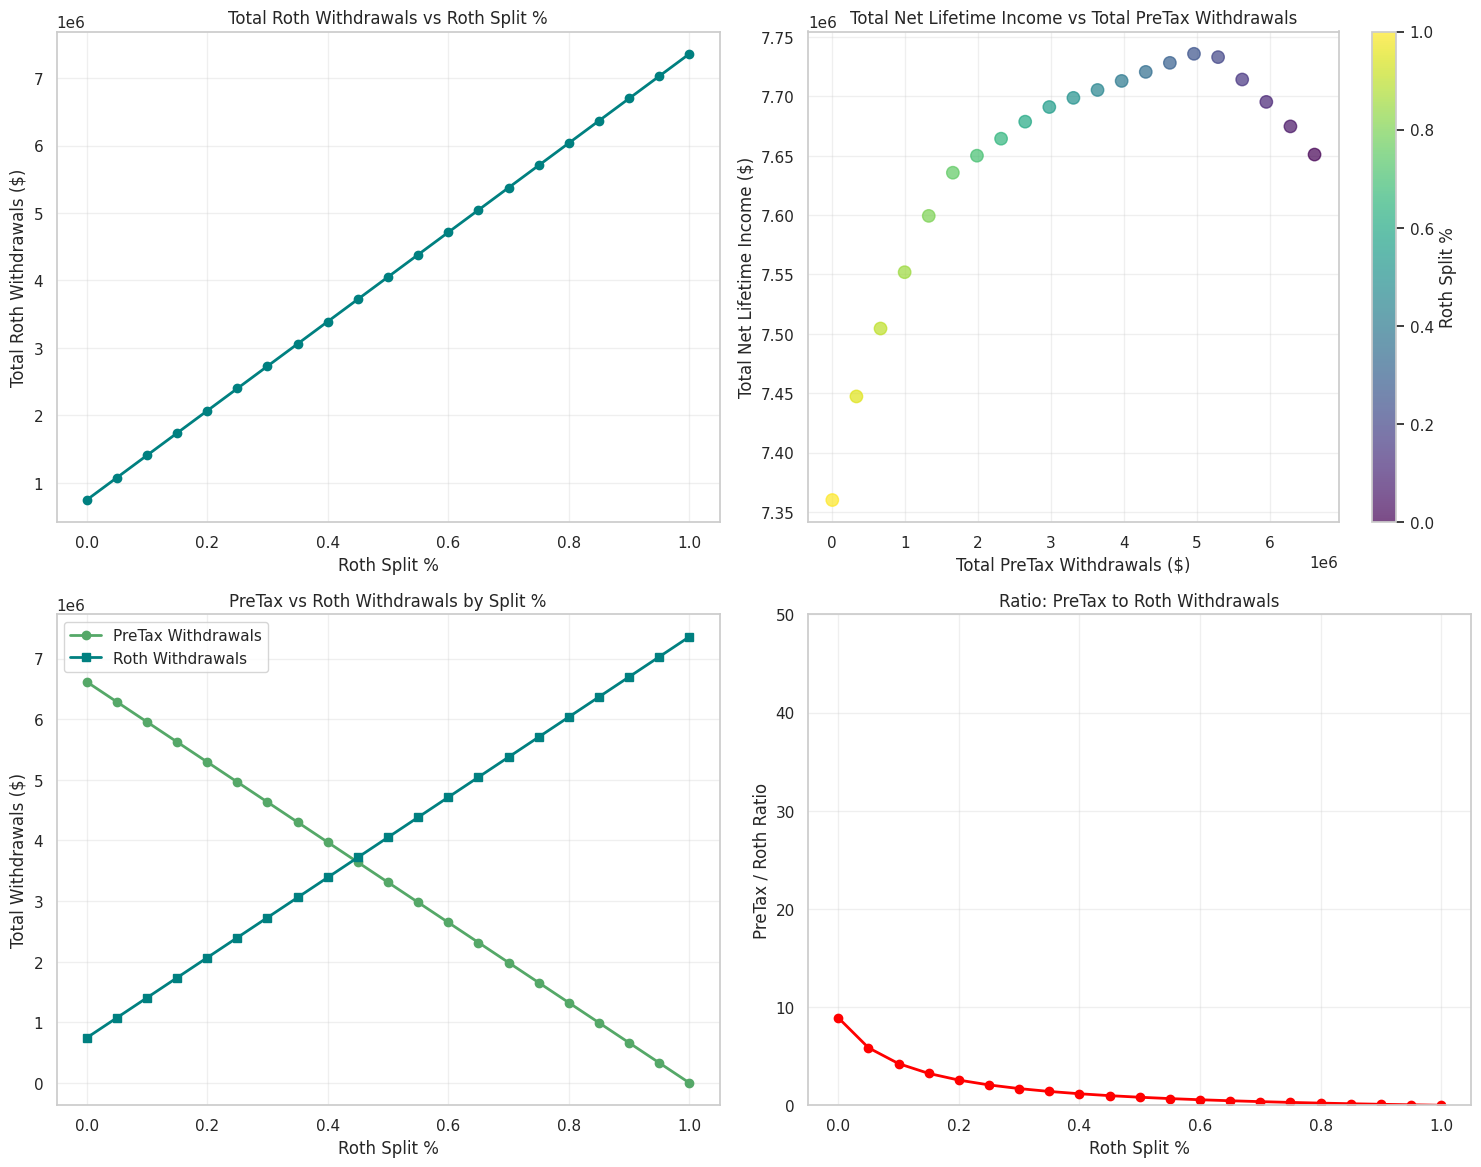


Key Data Points:
Equal PreTax/Roth Withdrawals at 45.0% Roth Split:
  PreTax: $3,639,408
  Roth: $3,720,660
  Net Income: $7,705,345

At 0% Roth (All Traditional):
  PreTax: $6,617,105
  Roth: $742,963
  Net Income: $7,650,961

At 100% Roth (No Traditional):
  PreTax: $0
  Roth: $7,360,068
  Net Income: $7,360,068


In [12]:
# Additional visualizations requested
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Roth Withdrawals vs Roth Split % (the inverse)
ax1.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_Roth_Withdrawals'], 'teal', marker='o', linewidth=2)
ax1.set_title('Total Roth Withdrawals vs Roth Split %')
ax1.set_xlabel('Roth Split %')
ax1.set_ylabel('Total Roth Withdrawals ($)')
ax1.grid(True, alpha=0.3)

# Plot 2: Total Net Lifetime Income (Y) vs Total PreTax Withdrawals (X)
scatter = ax2.scatter(df_detailed['Total_PreTax_Withdrawals'], df_detailed['Total_Net_Lifetime_Income'], 
                     c=df_detailed['Roth_Split_Percent'], cmap='viridis', s=80, alpha=0.7)
ax2.set_title('Total Net Lifetime Income vs Total PreTax Withdrawals')
ax2.set_xlabel('Total PreTax Withdrawals ($)')
ax2.set_ylabel('Total Net Lifetime Income ($)')
ax2.grid(True, alpha=0.3)
# Add colorbar to show Roth Split %
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Roth Split %')

# Plot 3: Both PreTax and Roth withdrawals on same chart
ax3.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_PreTax_Withdrawals'], 'g-o', linewidth=2, label='PreTax Withdrawals')
ax3.plot(df_detailed['Roth_Split_Percent'], df_detailed['Total_Roth_Withdrawals'], 'teal', marker='s', linewidth=2, label='Roth Withdrawals')
ax3.set_title('PreTax vs Roth Withdrawals by Split %')
ax3.set_xlabel('Roth Split %')
ax3.set_ylabel('Total Withdrawals ($)')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Ratio of PreTax to Roth Withdrawals
# Avoid division by zero
roth_nonzero = df_detailed['Total_Roth_Withdrawals'] > 0
pretax_to_roth_ratio = np.where(roth_nonzero, 
                                df_detailed['Total_PreTax_Withdrawals'] / df_detailed['Total_Roth_Withdrawals'],
                                np.inf)
ax4.plot(df_detailed['Roth_Split_Percent'], pretax_to_roth_ratio, 'red', marker='o', linewidth=2)
ax4.set_title('Ratio: PreTax to Roth Withdrawals')
ax4.set_xlabel('Roth Split %')
ax4.set_ylabel('PreTax / Roth Ratio')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 50)  # Cap the y-axis to make it readable

plt.tight_layout()
plt.show()

# Find some interesting data points
print("\nKey Data Points:")
print("=" * 50)

# Find where PreTax and Roth withdrawals are approximately equal
equal_point_idx = np.abs(df_detailed['Total_PreTax_Withdrawals'] - df_detailed['Total_Roth_Withdrawals']).idxmin()
equal_point = df_detailed.loc[equal_point_idx]
print(f"Equal PreTax/Roth Withdrawals at {equal_point['Roth_Split_Percent']:.1%} Roth Split:")
print(f"  PreTax: ${equal_point['Total_PreTax_Withdrawals']:,.0f}")
print(f"  Roth: ${equal_point['Total_Roth_Withdrawals']:,.0f}")
print(f"  Net Income: ${equal_point['Total_Net_Lifetime_Income']:,.0f}")

print(f"\nAt 0% Roth (All Traditional):")
all_trad = df_detailed.loc[df_detailed['Roth_Split_Percent'] == 0.0].iloc[0]
print(f"  PreTax: ${all_trad['Total_PreTax_Withdrawals']:,.0f}")
print(f"  Roth: ${all_trad['Total_Roth_Withdrawals']:,.0f}")
print(f"  Net Income: ${all_trad['Total_Net_Lifetime_Income']:,.0f}")

print(f"\nAt 100% Roth (No Traditional):")
all_roth = df_detailed.loc[df_detailed['Roth_Split_Percent'] == 1.0].iloc[0]
print(f"  PreTax: ${all_roth['Total_PreTax_Withdrawals']:,.0f}")
print(f"  Roth: ${all_roth['Total_Roth_Withdrawals']:,.0f}")
print(f"  Net Income: ${all_roth['Total_Net_Lifetime_Income']:,.0f}")


## Income vs PreTax Withdrawals by Starting Age
Recreating the "Total Net Lifetime Income vs Total PreTax Withdrawals" chart for different starting ages to see how the relationship changes based on when you begin contributing.

Generating data for different starting ages...
Processing age 25...
Processing age 30...
Processing age 35...
Processing age 40...
Processing age 45...
Processing age 50...
Processing age 55...


/tmp/ipykernel_85373/1192009765.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


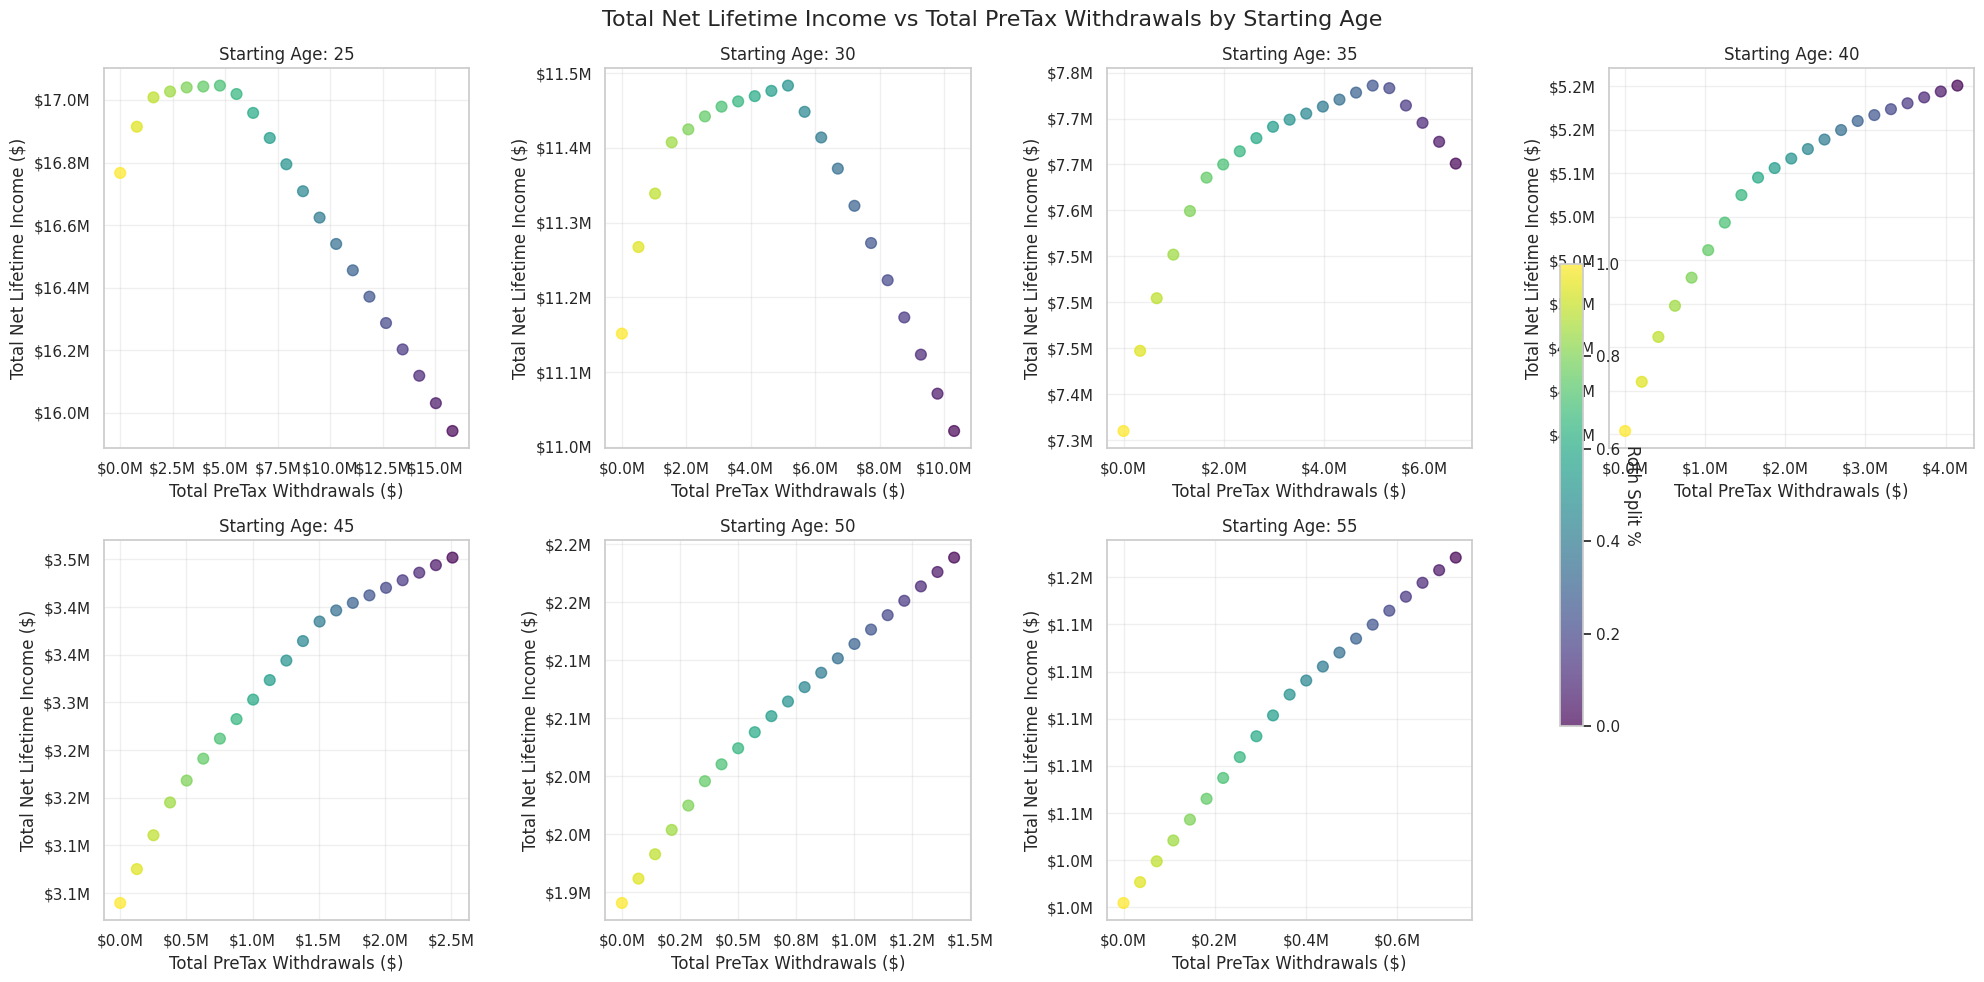

In [13]:
# Generate detailed data for different starting ages
ages = [25, 30, 35, 40, 45, 50, 55]
age_detailed_results = {}

print("Generating data for different starting ages...")
for age in ages:
    print(f"Processing age {age}...")
    p = params.copy()
    p['current_age'] = age
    age_detailed_results[age] = analyze_splits_detailed(p)

# Create individual charts for each starting age
# Adjust layout to avoid colorbar issues
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Store the last scatter plot for colorbar reference
last_scatter = None

for i, age in enumerate(ages):
    ax = axes[i]
    df_age = age_detailed_results[age]
    
    # Create the scatter plot with color-coded Roth Split %
    scatter = ax.scatter(df_age['Total_PreTax_Withdrawals'], df_age['Total_Net_Lifetime_Income'], 
                        c=df_age['Roth_Split_Percent'], cmap='viridis', s=60, alpha=0.7)
    last_scatter = scatter  # Keep reference to the last scatter plot
    
    ax.set_title(f'Starting Age: {age}')
    ax.set_xlabel('Total PreTax Withdrawals ($)')
    ax.set_ylabel('Total Net Lifetime Income ($)')
    ax.grid(True, alpha=0.3)
    
    # Format axes to use millions
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Remove the extra subplot
axes[-1].remove()

# Add a shared colorbar using the figure and the last scatter plot
if last_scatter is not None:
    # Create colorbar with proper positioning
    cbar = plt.colorbar(last_scatter, ax=axes[:-1], shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label('Roth Split %', rotation=270, labelpad=15)

plt.suptitle('Total Net Lifetime Income vs Total PreTax Withdrawals by Starting Age', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## Income vs PreTax Withdrawals by Income Level
Recreating the "Total Net Lifetime Income vs Total PreTax Withdrawals" chart for different income levels to see how the relationship changes based on earning capacity and tax brackets.

Generating data for different income levels...
Processing income $75,000...
Processing income $100,000...
Processing income $150,000...
Processing income $200,000...
Processing income $250,000...
Processing income $300,000...
Processing income $400,000...


/tmp/ipykernel_85373/3434246096.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


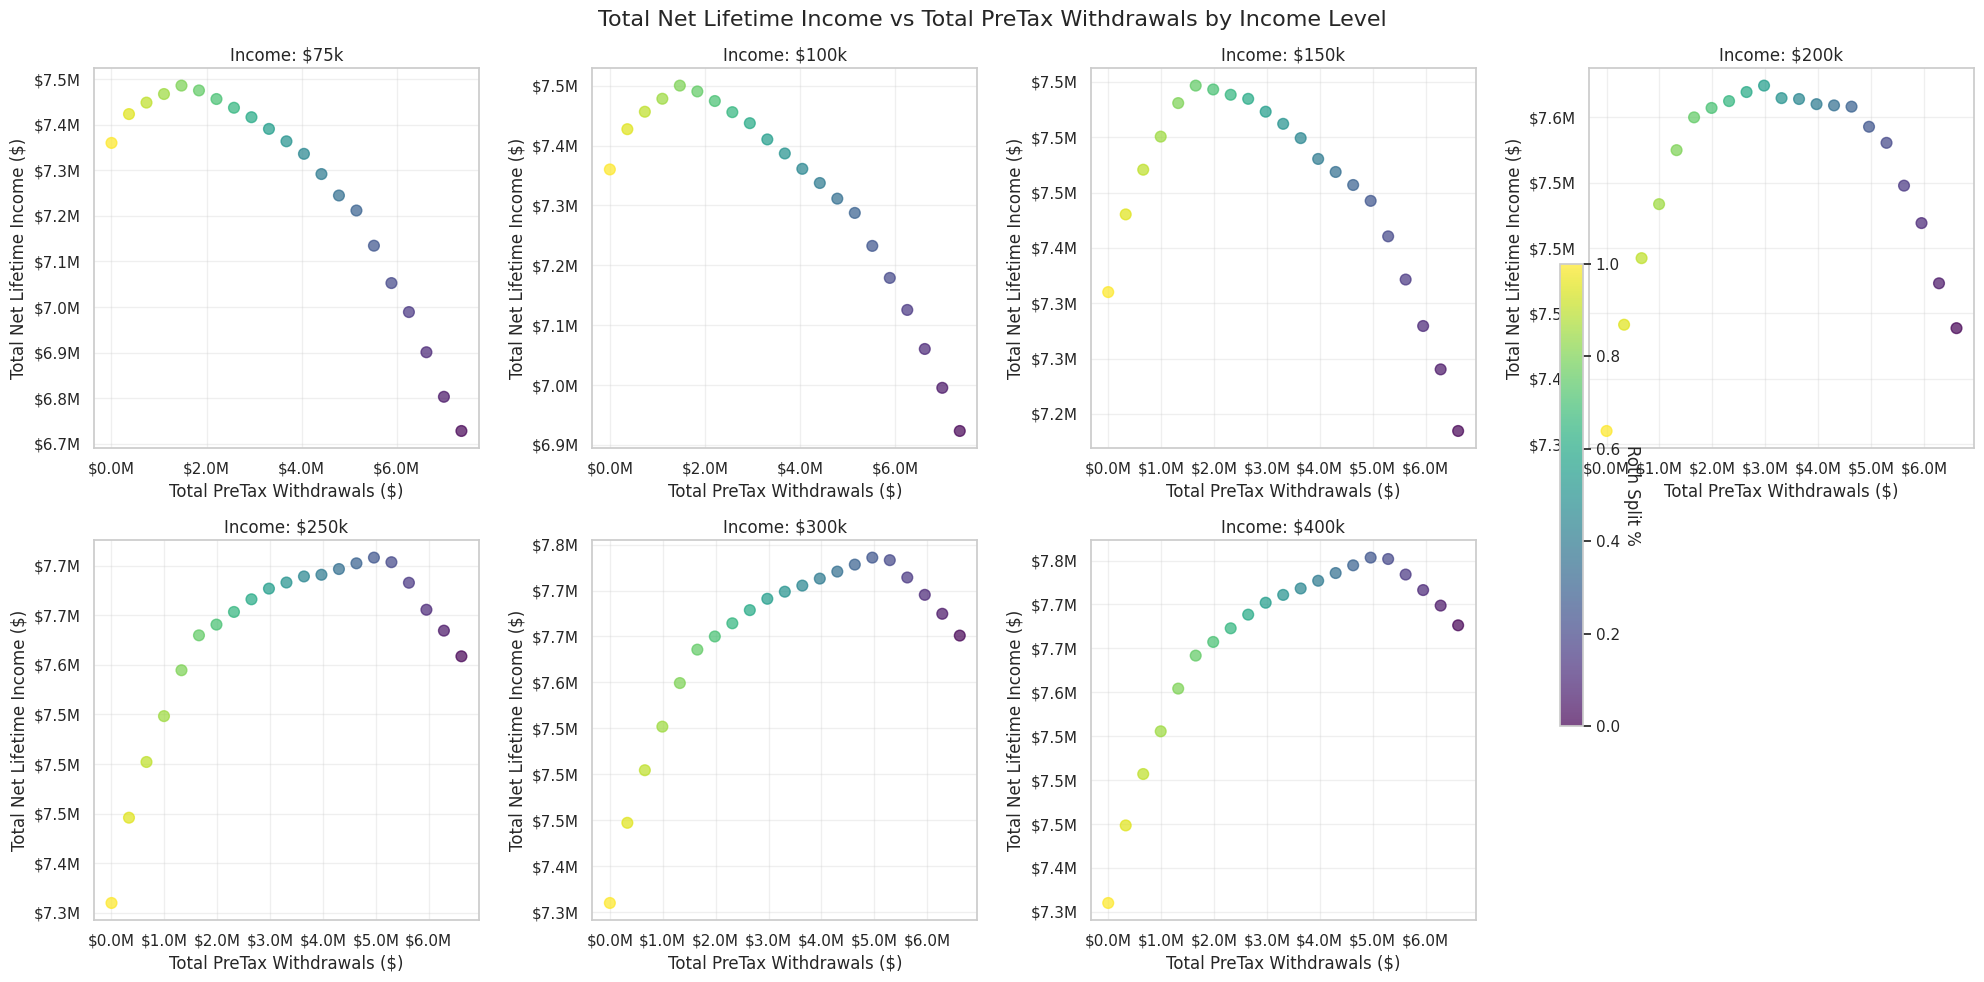

In [14]:
# Generate detailed data for different income levels
incomes = [75000, 100000, 150000, 200000, 250000, 300000, 400000]
income_detailed_results = {}

print("Generating data for different income levels...")
for income in incomes:
    print(f"Processing income ${income:,}...")
    p = params.copy()
    p['annual_income'] = income
    income_detailed_results[income] = analyze_splits_detailed(p)

# Create individual charts for each income level
# Adjust layout to avoid colorbar issues
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Store the last scatter plot for colorbar reference
last_scatter = None

for i, income in enumerate(incomes):
    ax = axes[i]
    df_income = income_detailed_results[income]
    
    # Create the scatter plot with color-coded Roth Split %
    scatter = ax.scatter(df_income['Total_PreTax_Withdrawals'], df_income['Total_Net_Lifetime_Income'], 
                        c=df_income['Roth_Split_Percent'], cmap='viridis', s=60, alpha=0.7)
    last_scatter = scatter  # Keep reference to the last scatter plot
    
    ax.set_title(f'Income: ${income/1000:.0f}k')
    ax.set_xlabel('Total PreTax Withdrawals ($)')
    ax.set_ylabel('Total Net Lifetime Income ($)')
    ax.grid(True, alpha=0.3)
    
    # Format axes to use millions
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Remove the extra subplot
axes[-1].remove()

# Add a shared colorbar using the figure and the last scatter plot
if last_scatter is not None:
    # Create colorbar with proper positioning
    cbar = plt.colorbar(last_scatter, ax=axes[:-1], shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label('Roth Split %', rotation=270, labelpad=15)

plt.suptitle('Total Net Lifetime Income vs Total PreTax Withdrawals by Income Level', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


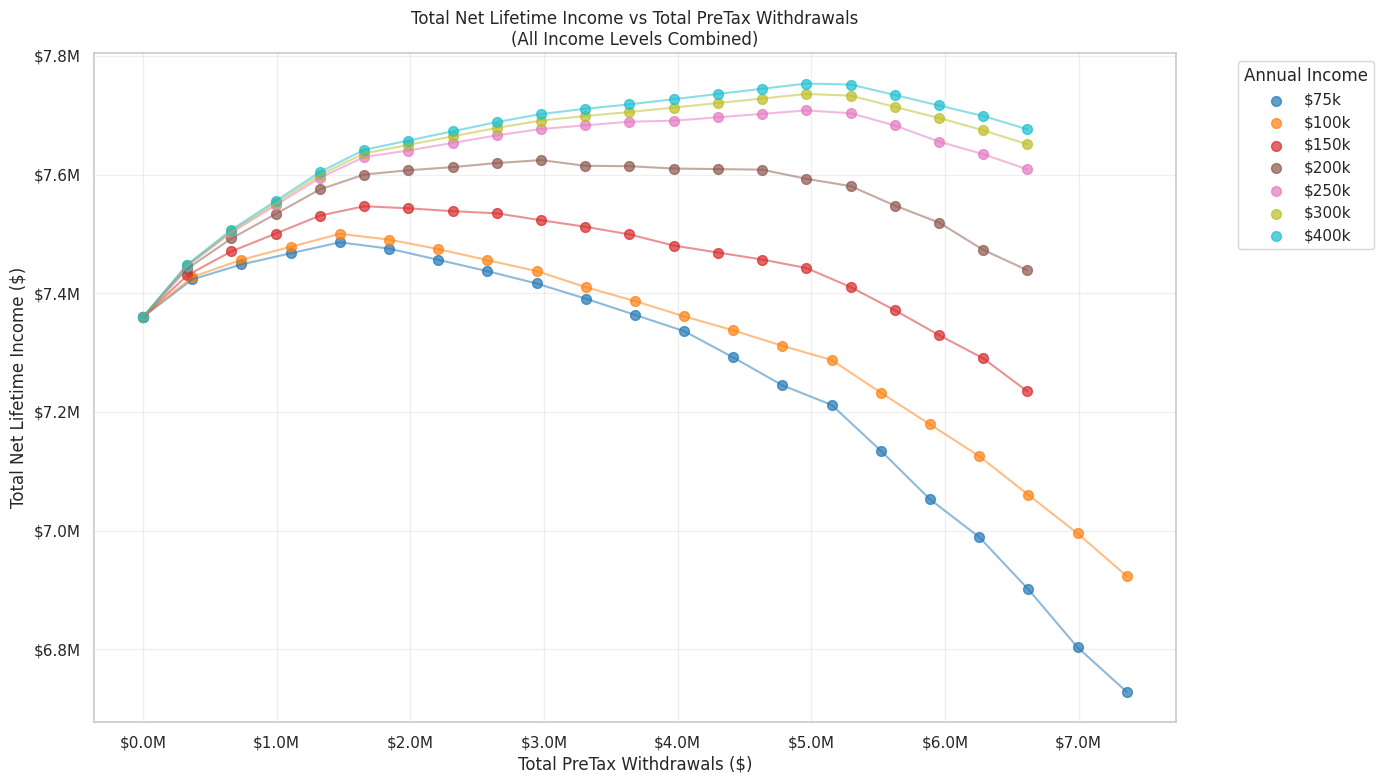

In [15]:
# Create a combined chart showing all income levels on one plot
plt.figure(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(incomes)))

for i, income in enumerate(incomes):
    df_income = income_detailed_results[income]
    
    # Plot each income as a different colored line/curve
    plt.scatter(df_income['Total_PreTax_Withdrawals'], df_income['Total_Net_Lifetime_Income'], 
               color=colors[i], label=f'${income/1000:.0f}k', alpha=0.7, s=50)
    
    # Add a trend line for each income
    # Sort by PreTax Withdrawals for proper line plotting
    df_sorted = df_income.sort_values('Total_PreTax_Withdrawals')
    plt.plot(df_sorted['Total_PreTax_Withdrawals'], df_sorted['Total_Net_Lifetime_Income'], 
            color=colors[i], alpha=0.5, linewidth=1.5)

plt.xlabel('Total PreTax Withdrawals ($)')
plt.ylabel('Total Net Lifetime Income ($)')
plt.title('Total Net Lifetime Income vs Total PreTax Withdrawals\n(All Income Levels Combined)')
plt.legend(title='Annual Income', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Format axes to use millions
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()


Analysis Summary by Income Level:
\nIncome Level $75,000:
  Optimal Roth Split: 80.0%
  At Optimal:
    - Net Income: $7,485,794
    - PreTax Withdrawals: $1,472,014
  Range:
    - PreTax Withdrawals: $0 to $7,360,068
    - Net Income: $6,728,196 to $7,485,794
    - Income Range: $757,598
\nIncome Level $100,000:
  Optimal Roth Split: 80.0%
  At Optimal:
    - Net Income: $7,500,135
    - PreTax Withdrawals: $1,472,014
  Range:
    - PreTax Withdrawals: $0 to $7,360,068
    - Net Income: $6,923,202 to $7,500,135
    - Income Range: $576,933
\nIncome Level $150,000:
  Optimal Roth Split: 75.0%
  At Optimal:
    - Net Income: $7,546,601
    - PreTax Withdrawals: $1,654,276
  Range:
    - PreTax Withdrawals: $0 to $6,617,105
    - Net Income: $7,234,603 to $7,546,601
    - Income Range: $311,998
\nIncome Level $200,000:
  Optimal Roth Split: 55.0%
  At Optimal:
    - Net Income: $7,624,357
    - PreTax Withdrawals: $2,977,697
  Range:
    - PreTax Withdrawals: $0 to $6,617,105
    - Net I

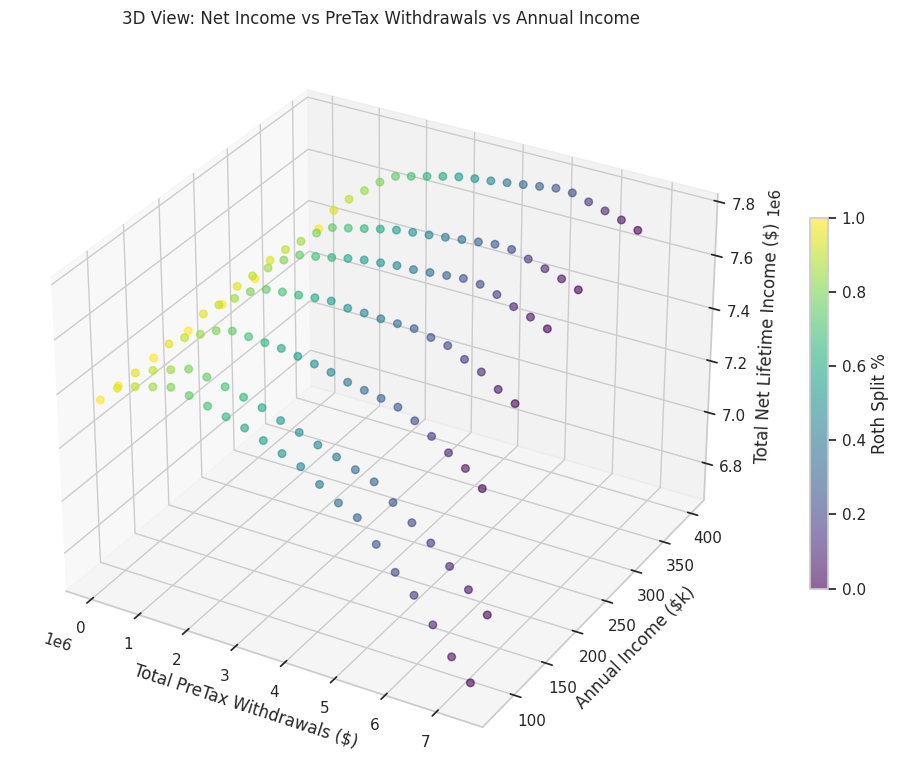

In [16]:
# Summary analysis of how income level affects the relationship
print("Analysis Summary by Income Level:")
print("=" * 60)

for income in incomes:
    df_income = income_detailed_results[income]
    
    # Find optimal point (max net income)
    optimal_idx = df_income['Total_Net_Lifetime_Income'].idxmax()
    optimal_data = df_income.loc[optimal_idx]
    
    # Find range of values
    min_pretax = df_income['Total_PreTax_Withdrawals'].min()
    max_pretax = df_income['Total_PreTax_Withdrawals'].max()
    min_net_income = df_income['Total_Net_Lifetime_Income'].min()
    max_net_income = df_income['Total_Net_Lifetime_Income'].max()
    
    print(f"\\nIncome Level ${income:,}:")
    print(f"  Optimal Roth Split: {optimal_data['Roth_Split_Percent']:.1%}")
    print(f"  At Optimal:")
    print(f"    - Net Income: ${optimal_data['Total_Net_Lifetime_Income']:,.0f}")
    print(f"    - PreTax Withdrawals: ${optimal_data['Total_PreTax_Withdrawals']:,.0f}")
    print(f"  Range:")
    print(f"    - PreTax Withdrawals: ${min_pretax:,.0f} to ${max_pretax:,.0f}")
    print(f"    - Net Income: ${min_net_income:,.0f} to ${max_net_income:,.0f}")
    print(f"    - Income Range: ${max_net_income - min_net_income:,.0f}")

# Create a 3D visualization option for income levels
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Combine all data for 3D plot
for i, income in enumerate(incomes):
    df_income = income_detailed_results[income]
    
    # Create income array for Z-axis (convert to thousands for readability)
    income_values = np.full(len(df_income), income/1000)
    
    scatter = ax.scatter(df_income['Total_PreTax_Withdrawals'], 
                        income_values,
                        df_income['Total_Net_Lifetime_Income'],
                        c=df_income['Roth_Split_Percent'], 
                        cmap='viridis', 
                        alpha=0.6, 
                        s=30)

ax.set_xlabel('Total PreTax Withdrawals ($)')
ax.set_ylabel('Annual Income ($k)')
ax.set_zlabel('Total Net Lifetime Income ($)')
ax.set_title('3D View: Net Income vs PreTax Withdrawals vs Annual Income')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20)
cbar.set_label('Roth Split %')

plt.tight_layout()
plt.show()


## Experiment 8: Effect of Retirement Income
Retirement income (pensions, Social Security, annuities) affects your tax bracket during retirement.
Higher retirement income may make Roth contributions more attractive since they don't add to taxable income.
Results are normalized for comparison.

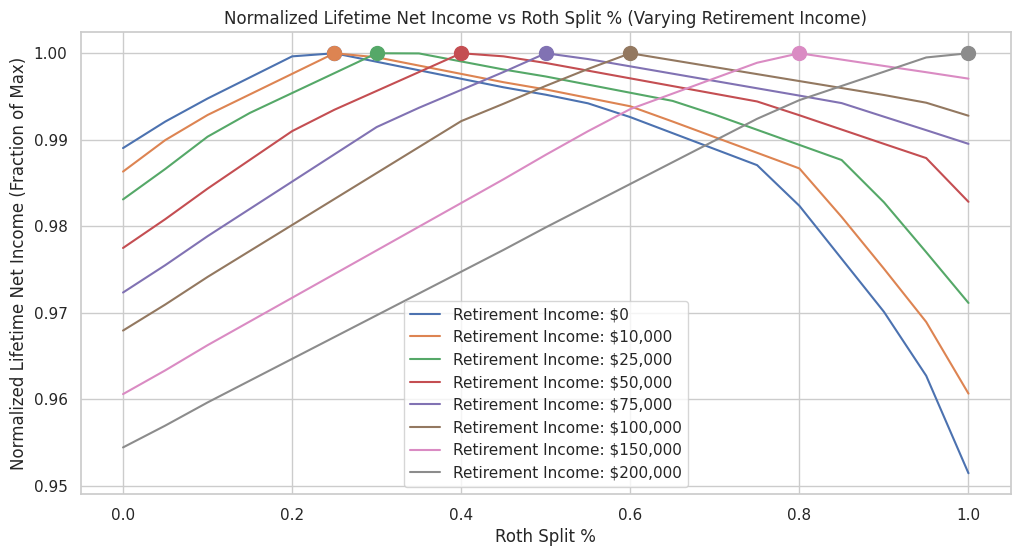


Optimal Roth Split Percentages by Retirement Income:


,Retirement Income,Optimal Roth Split %,Max Normalized Income
0,$0,0.25,1.0
1,"$10,000",0.25,1.0
2,"$25,000",0.30,1.0
3,"$50,000",0.40,1.0
4,"$75,000",0.50,1.0
5,"$100,000",0.60,1.0
6,"$150,000",0.80,1.0
7,"$200,000",1.00,1.0


In [19]:
retirement_incomes = [0, 10000, 25000, 50000, 75000, 100000, 150000, 200000]
results_by_retirement_income = {}

for ret_income in retirement_incomes:
    p = params.copy()
    p['retirement_income'] = ret_income
    df = analyze_splits(p)
    # Normalize
    df['Normalized_Income'] = df['Total_Net_Lifetime_Income'] / df['Total_Net_Lifetime_Income'].max()
    results_by_retirement_income[ret_income] = df

optimal_results = []
plt.figure(figsize=(12, 6))
for ret_income, df in results_by_retirement_income.items():
    sns.lineplot(data=df, x='Roth_Split_Percent', y='Normalized_Income', 
                label=f'Retirement Income: ${ret_income:,}')
    
    # Get the color of the line that was just plotted
    line_color = plt.gca().lines[-1].get_color()
    
    # Find the point with the maximum Normalized_Income
    max_income_row = df.loc[df['Normalized_Income'].idxmax()]
    optimal_split = max_income_row['Roth_Split_Percent']
    max_income = max_income_row['Normalized_Income']
    
    # Highlight the optimal point with a circle of the same color
    plt.scatter(optimal_split, max_income, color=line_color, s=100, marker='o', zorder=5)

    optimal_results.append({
        'Retirement Income': f'${ret_income:,}',
        'Optimal Roth Split %': optimal_split,
        'Max Normalized Income': max_income
    })

plt.title('Normalized Lifetime Net Income vs Roth Split % (Varying Retirement Income)')
plt.xlabel('Roth Split %')
plt.ylabel('Normalized Lifetime Net Income (Fraction of Max)')
plt.legend()
plt.show()

optimal_df = pd.DataFrame(optimal_results)
print("\nOptimal Roth Split Percentages by Retirement Income:")
display(optimal_df)
